<a href="https://colab.research.google.com/github/IsitaRex/Vibe-Sorcery/blob/main/VibeSorcery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vibe Sorcery 🎼🔮  
**Summoning the perfect song for your mood, every time.**

Vibe Sorcery is a mood-based playlist generator designed to create seamless, emotionally cohesive playlists. The core idea is simple: a great playlist isn’t just a random collection of songs—it’s a journey. By ensuring smooth transitions between tracks and maintaining a consistent emotional vibe, Vibe Sorcerer crafts playlists that feel intentional and immersive.

Vibe Sorcery is implemented through a series of Python classes, each handling a specific step in the playlist generation process.

**Steps:**
1. Choose a song
2. `class Listener`: Use MTG Listening Models to identify the most relevant moods of the song
3. `class Captioner`: Generate a caption of the song based on the mood
4. `class Generator`:Generate a song based on the caption of the previous song
5. `class VibeSorcery`: This class integrates the Listener, Captioner and Generator. Then, repeat the process until you have your desired number of songs for the playlist
6. `class Evaluator`: Evaluate the quality of the playlist

First we are going to install the dependencies we need

In [ ]:
# !pip install essentia-tensorflow
# !pip install transformers
# !pip install diffusers
# !pip uninstall numpy -y
# !pip install numpy==1.26.4 # Numpy < 2.0 needed for Essentia
# !pip install librosa
# !pip install torchsde
# !pip install accelerate

Now, we are going to download the models we need

In [ ]:
# !wget https://essentia.upf.edu/models/music-style-classification/discogs-effnet/discogs-effnet-bs64-1.pb
# !wget https://essentia.upf.edu/models/classification-heads/mtg_jamendo_moodtheme/mtg_jamendo_moodtheme-discogs-effnet-1.pb
# !wget https://essentia.upf.edu/models/classification-heads/deam/deam-audioset-vggish-2.pb
# !wget https://essentia.upf.edu/models/feature-extractors/vggish/audioset-vggish-3.pb

# Step 1 💿: Choose a song

Create a folder called `Playlist` and inside the folder upload the input song as `playlist_song_0.wav`

In [ ]:
import librosa
import librosa.display
import IPython.display as ipd

audio_path = 'Playlist/playlist_song_0.wav'
audio_data, sample_rate = librosa.load(audio_path)

ipd.Audio(audio_data, rate=sample_rate)

# Step 2🤔: Detect the moods of the song

To detect the moods of the song we are going to use MTG Listening models via [Essentia](https://essentia.upf.edu/) library. The `Listener` class represents the input song using `Discogs-EffNet` embeddings and then uses those embeddings to classify moods and themes of the song
a pre-trained model to classify with mood and theme subset of the MTG-Jamendo Dataset (56 classes):

In [ ]:
mood_tags = [
  "action", "adventure", "advertising", "background", "ballad", "calm",
  "children", "christmas", "commercial", "cool", "corporate",
  "dark", "deep", "documentary", "drama", "dramatic",
  "dream", "emotional", "energetic", "epic", "fast",
  "film", "fun", "funny", "game", "groovy",
  "happy", "heavy", "holiday", "hopeful", "inspiring",
  "love", "meditative", "melancholic", "melodic", "motivational",
  "movie", "nature", "party", "positive", "powerful",
  "relaxing", "retro", "romantic", "sad", "sexy",
  "slow", "soft", "soundscape", "space", "sport",
  "summer", "trailer", "travel", "upbeat", "uplifting"
]

In [ ]:
from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D
import numpy as np

class Listener:
    '''
    This class is used to extract mood features from a song using pre-trained models.
    It uses the Essentia library to load the audio file and extract features.
    '''

    def __init__(self, model_path_embeddings = "discogs-effnet-bs64-1.pb", model_path_classification = "mtg_jamendo_moodtheme-discogs-effnet-1.pb"):

        self.embeddings_model_moods = TensorflowPredictEffnetDiscogs(
            graphFilename=model_path_embeddings,
            output="PartitionedCall:1",
        )

        self.mood_classification_model = TensorflowPredict2D(
            graphFilename=model_path_classification,
            output='model/Sigmoid',
        )

    def get_moods_from_song(self, song_path, threshold=0.07):
        '''
        This function takes a song path and returns the moods detected in the song.
        It uses the pre-trained models to extract features and classify the moods.

        Args:
          song_path (str): The path to the song file.
          threshold (float): The threshold value to filter moods.

        Returns:
          list: A list of moods detected in the song.
        '''
        audio = MonoLoader(filename=song_path, sampleRate=32000)()
        embeddings = self.embeddings_model_moods(audio)
        activations = self.mood_classification_model(embeddings)

        activation_avs = []
        for i in range(len(activations[0])):
            vals = [activations[j][i] for j in range(len(activations))]
            activation_avs.append(sum(vals) / len(vals))

        activations_dict = {tag: activation_avs[ind] for ind, tag in enumerate(mood_tags)}

        # Filter moods based on the threshold
        moods_above_threshold = [mood for mood, value in activations_dict.items() if value > threshold]
        if len(moods_above_threshold)  < 4:
            # If no moods are above the threshold, return the top k moods
            sorted_moods = sorted(activations_dict.items(), key=lambda item: item[1], reverse=True)
            return [mood for mood, _ in sorted_moods[:4]]

        return moods_above_threshold

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [ ]:
listener = Listener() # Create an instance of the listener
song_path = 'Playlist/playlist_song_0.wav'

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `discogs-effnet-bs64-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mtg_jamendo_moodtheme-discogs-effnet-1.pb`


In [ ]:
moods = listener.get_moods_from_song(song_path, threshold=0.07)
print("Moods detected:", moods)

Moods detected: ['dark', 'soundscape', 'space', 'film']


# Step 3 📝: Generate song caption

Based on the moods extracted from the song, the Captioner is going to generarate a caption of the song, which is also going to be the input caption for the next song.

In [ ]:
mood_synonyms = {
            "action": ["intense", "thrilling", "dynamic", "explosive", "pumping"],
            "adventure": ["exploratory", "journey", "quest", "expedition", "voyage"],
            "advertising": ["promotional", "catchy", "jingle", "branded", "commercial"],
            "background": ["ambient", "subtle", "unobtrusive", "atmospheric", "underscore"],
            "ballad": ["storytelling", "narrative", "emotional", "heartfelt", "intimate"],
            "calm": ["peaceful", "serene", "tranquil", "soothing", "gentle"],
            "children": ["playful", "whimsical", "innocent", "youthful", "fun"],
            "christmas": ["festive", "holiday", "cheerful", "jolly", "wintry"],
            "commercial": ["catchy", "memorable", "upbeat", "positive", "energetic"],
            "cool": ["chill", "laid-back", "smooth", "relaxed", "mellow"],
            "corporate": ["professional", "polished", "refined", "sleek", "business"],
            "dark": ["brooding", "ominous", "mysterious", "gloomy", "shadowy"],
            "deep": ["profound", "thoughtful", "philosophical", "introspective", "meaningful"],
            "documentary": ["informative", "educational", "factual", "realistic", "authentic"],
            "drama": ["theatrical", "expressive", "passionate", "intense", "serious"],
            "dramatic": ["theatrical", "grand", "powerful", "stirring", "emotive"],
            "dream": ["ethereal", "surreal", "fantastical", "otherworldly", "floaty"],
            "emotional": ["feeling", "sentimental", "expressive", "touching", "moving"],
            "energetic": ["lively", "vibrant", "animated", "spirited", "exuberant"],
            "epic": ["grandiose", "majestic", "heroic", "monumental", "cinematic"],
            "fast": ["rapid", "quick", "speedy", "brisk", "up-tempo"],
            "film": ["cinematic", "soundtrack", "orchestral", "visual", "thematic"],
            "fun": ["playful", "joyful", "lighthearted", "cheerful", "amusing"],
            "funny": ["humorous", "comical", "witty", "silly", "laughable"],
            "game": ["interactive", "playful", "competitive", "immersive", "virtual"],
            "groovy": ["funky", "rhythmic", "danceable", "syncopated", "boogie"],
            "happy": ["joyful", "cheerful", "upbeat", "sunny", "positive"],
            "heavy": ["intense", "powerful", "weighty", "forceful", "aggressive"],
            "holiday": ["festive", "celebratory", "seasonal", "vacation", "cheerful"],
            "hopeful": ["optimistic", "promising", "encouraging", "bright", "positive"],
            "inspiring": ["motivational", "uplifting", "encouraging", "stimulating", "empowering"],
            "love": ["romantic", "affectionate", "passionate", "tender", "intimate"],
            "meditative": ["contemplative", "reflective", "zen", "calm", "peaceful"],
            "melancholic": ["nostalgic", "wistful", "bittersweet", "pensive", "sorrowful"],
            "melodic": ["tuneful", "harmonious", "musical", "lyrical", "catchy"],
            "motivational": ["inspirational", "encouraging", "empowering", "rousing", "stimulating"],
            "movie": ["cinematic", "filmic", "theatrical", "dramatic", "narrative"],
            "nature": ["organic", "natural", "earthy", "outdoors", "environmental"],
            "party": ["festive", "celebratory", "lively", "fun", "social"],
            "positive": ["optimistic", "upbeat", "cheerful", "happy", "bright"],
            "powerful": ["strong", "forceful", "intense", "potent", "dynamic"],
            "relaxing": ["calming", "soothing", "peaceful", "restful", "tranquil"],
            "retro": ["vintage", "nostalgic", "classic", "old-school", "throwback"],
            "romantic": ["loving", "passionate", "intimate", "affectionate", "sentimental"],
            "sad": ["mournful", "sorrowful", "melancholy", "blue", "heartbreaking"],
            "sexy": ["sensual", "seductive", "alluring", "provocative", "flirtatious"],
            "slow": ["leisurely", "unhurried", "measured", "languid", "deliberate"],
            "soft": ["gentle", "quiet", "delicate", "muted", "subtle"],
            "soundscape": ["textural", "environmental", "immersive", "atmospheric", "ambient"],
            "space": ["cosmic", "stellar", "astral", "celestial", "interstellar"],
            "sport": ["athletic", "energetic", "competitive", "dynamic", "active"],
            "summer": ["sunny", "warm", "bright", "carefree", "vacation"],
            "trailer": ["teaser", "promotional", "cinematic", "dramatic", "epic"],
            "travel": ["wanderlust", "exploration", "journey", "adventure", "movement"],
            "upbeat": ["cheerful", "lively", "positive", "energetic", "bouncy"],
            "uplifting": ["inspiring", "encouraging", "heartening", "positive", "elevating"]
        }

In [ ]:
import random
from typing import List, Dict, Set, Optional, Tuple, Union

class Captioner:
    """
    Class to generate captions for songs based on their mood.
    It uses grammars and synonyms to create unique descriptions.
    """

    def __init__(self):
        self.mood_synonyms = mood_synonyms
        self.grammar_templates = self._initialize_grammar_templates()

    def _initialize_grammar_templates(self) -> List[List[str]]:
        """
        Initializes the grammar templates used for generating captions.
        """
        return [
            ["A", "{mood}", "song"],
            ["A", "{mood}", "tune for your", "{mood}", "moments"],
            ["The perfect", "{mood}", "soundtrack for your day"],
            ["A song that blends", "{mood}", "and", "{mood}", "vibes"],
            ["A", "{mood}", "song with hints of", "{mood}", "undertones"],
            ["A", "{mood}", "composition with", "{mood}", "undertones"],
            ["Music to feel", "{mood}", "and", "{mood}"],
            ["A song that evoques a", "{mood}", "atmosphere with", "{mood}", "progressions"]
        ]

    def get_synonym(self, mood: str) -> str:
        """
        Get a random synonym for a given mood.

        Args:
            mood (str): The mood for which to find a synonym.

        Returns:
            str: A random synonym.
        """
        synonyms = self.mood_synonyms.get(mood, [mood])
        return random.choice(synonyms)

    def _generate_mood_subsets(self, moods: List[str]) -> Tuple[List[str], List[str]]:
        """
        Generates non-overlapping subsets of moods for primary and secondary moods.

        Args:
            moods (List[str]): List of available moods

        Returns:
            Tuple[List[str], List[str]]: (primary_moods, secondary_moods)
        """
        # Determine split point (at least 1 mood for each subset)
        split_point = random.randint(1, len(moods) - 1)

        primary_moods = moods[:split_point]
        secondary_moods = moods[split_point:]

        # Take a random sample of moods for both primary and secondary
        primary_moods = random.sample(primary_moods, k=random.randint(1, len(primary_moods)))
        secondary_moods = random.sample(secondary_moods, k=random.randint(1, len(secondary_moods)))

        return (primary_moods, secondary_moods)

    def _join_moods(self, moods: List[str]) -> str:
        """
        Joins a list of moods into a comma-separated string with proper grammar.

        Args:
            moods (List[str]): List of moods to join

        Returns:
            str: Comma-separated string of moods
        """
        if len(moods) == 1:
            return moods[0]
        return ", ".join(moods[:-1]) + " and " + moods[-1]

    def _generate_caption(self, primary_moods: List[str], secondary_moods: Optional[List[str]] = None) -> str:
        """
        Generates a unique caption based on the primary and optional secondary moods.

        Args:
            primary_moods (List[str]): The primary moods of the song.
            secondary_moods (List[str], optional): Optional secondary moods.

        Returns:
            str: A generated caption.
        """
        # Choose a random template
        template = random.choice(self.grammar_templates)
        first_part = False

        # Process the template
        caption_parts = []
        for part in template:
            if part == "{mood}":
                if not first_part:
                    # Use the first primary mood
                    use_mood = primary_moods
                    first_part = True
                else:
                    use_mood = secondary_moods
                caption_parts.append(", ".join(use_mood))
            else:
                caption_parts.append(part)

        # Join the parts to form the final caption
        caption = " ".join(caption_parts)
        return caption[0].upper() + caption[1:]

    def generate_from_moods(self, moods: List[str]) -> str:
        """
        Generate a caption based on a list of moods.

        Args:
            moods (List[str]): List of moods to base the caption on.

        Returns:
            str: Generated description.
        """
        # Use synonyms for the moods base on random chance
        moods = [self.get_synonym(mood) if random.random() > 0.5 else mood for mood in moods]

        # Generate random subsets of moods
        primary_moods, secondary_moods = self._generate_mood_subsets(moods)

        # Generate caption with the mood subsets
        return self._generate_caption(primary_moods, secondary_moods)

In [ ]:
captioner = Captioner()
caption = captioner.generate_from_moods(moods)
print("Generated caption:", caption)

Generated caption: A song that evoques a monumental, dark atmosphere with meditative, intimate progressions


# Step 4 🎶: Generate next song

The Generator class is implemented to generate the next song using [Stable Audio](https://huggingface.co/stabilityai/stable-audio-open-1.0). The input for the generation is the caption generated by the Captioner from the previous song

In [ ]:
# !huggingface-cli login --token {PASTE_YOUR TOKEN HERE}

In [ ]:
import os
import torch
import soundfile as sf
from typing import Optional, Union, List, Dict
from diffusers import StableAudioPipeline

class Generator:
    """
    Class to generate music from textual descriptions using diffusion models like StableAudio.
    """

    def __init__(self, model_name: str = "stabilityai/stable-audio-open-1.0",
                 device: str = None,
                 output_dir: str = "Playlist"):
        """
        Initializes the Generator with the specified model and device.

        Args:
            model_name (str): Name of the model to use for generation.
            device (str): Device to run the model on. Options are "cuda", "mps", or "cpu".
            output_dir (str): Directory to save the generated audio files.
        """
        self.model_name = model_name

        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        else:
            self.device = device

        print(f'Using device: {self.device}')

        self.output_dir = output_dir

        # Create the output directory if it doesn't exist
        os.makedirs(self.output_dir, exist_ok=True)

        # load the model
        try:
            self.pipe = StableAudioPipeline.from_pretrained(
                self.model_name,
                torch_dtype=torch.float16 if self.device == "cuda" else torch.float32
            )
            self.pipe = self.pipe.to(self.device)
            print(f"Model {self.model_name} loaded on {self.device}")
        except Exception as e:
            print(f"Error to load the model: {e}")
            self.pipe = None

    def generate_song(self,
                      prompt: str,
                      negative_prompt: str = "Low quality, noise, distortion, artifacts",
                      duration: float = 47.0,
                      seed: Optional[int] = None,
                      filename: Optional[str] = None,
                      return_audio: bool = False) -> Optional[torch.Tensor]:
        """
        Generates a song based on the provided prompt and saves it to a file.

        Args:
            prompt (str): Description of the song to generate.
            negative_prompt (str): Features to avoid in the generation.
            duration (float): Duration of the song in seconds.
            seed (int, optional): Seed for random number generation.
            filename (str, optional): Name of the output file. If None, a default name is generated.
            return_audio (bool): True to return the generated audio tensor, False to just save it.

        Returns:
            torch.Tensor or None: El tensor de audio si return_audio es True,
                                 None en caso contrario.
        """
        if self.pipe is None:
            print("No model loaded. Please initialize the generator first.")
            return None

        try:
            if seed is not None:
                gen = torch.Generator(self.device).manual_seed(seed)
            else:
                gen = torch.Generator(self.device).manual_seed(torch.randint(0, 1000000, (1,)).item())

            # Generate audio
            audio = self.pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                audio_end_in_s=duration,
                num_waveforms_per_prompt=1,
                generator=gen,
            ).audios

            output = audio[0].T.float().cpu().numpy()

            # Create name if not provided
            if filename is None:
                files = [f for f in os.listdir(self.output_dir) if f.startswith("playlist_song_") and f.endswith(".wav")]
                if files:
                    # Get the last number used
                    last_number = max([int(f.split("_")[-1].split(".")[0]) for f in files])
                    filename = f"playlist_song_{last_number + 1}.wav"
                else:
                    filename = "playlist_song_1.wav"

            # Save the audio to a file
            filepath = os.path.join(self.output_dir, filename)
            sf.write(filepath, output, self.pipe.vae.sampling_rate)
            print(f"Song generated in: {filepath}")

            return filepath

        except Exception as e:
            print(f"Error generating the song: {e}")
            return None

    def get_model_info(self) -> Dict:
        """
        Obtiene información sobre el modelo cargado.

        Returns:
            Dict: Diccionario con información del modelo.
        """
        if self.pipe is None:
            return {"status": "No disponible", "error": "Modelo no inicializado"}

        return {
            "model_name": self.model_name,
            "device": self.device,
            "output_directory": self.output_dir,
            "sampling_rate": self.pipe.vae.sampling_rate if hasattr(self.pipe, "vae") else "desconocido"
        }

In [ ]:
generator = Generator()

Using device: cuda


Loading pipeline components...:  67%|██████▋   | 4/6 [00:05<00:03,  1.64s/it]/opt/conda/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Loading pipeline components...: 100%|██████████| 6/6 [00:34<00:00,  5.75s/it]


Error to load the model: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 


In [ ]:
generator.generate_song(prompt = caption)

No model loaded. Please initialize the generator first.


# Step 5 🎶: Generate a full playlist

The `class VibeSorcery` integrates the Listener, Captioner and Generator to generate a full playlist with a desired number of songs. The maximum length for the songs is 47 seconds which is the maximum length allowed by Stable Audio

In [ ]:
# del generator
# del listener
# del captioner
# del vibe_sorcerer

In [ ]:
import os
import time
import librosa
import numpy as np
from typing import List, Dict, Tuple, Optional, Union
from pathlib import Path

class VibeSorcery:
    """
    Class to generate a playlist of songs based on the mood of an input song.
    1. Detects the mood of an input song using the Listener component. (Listener)
    2. Generates captions based on the detected mood using the Captioner component. (Captioner)
    3. Creates new songs based on the generated captions using the Generator component. (Generator)
    4. Uses the generated songs as input for the next iteration.
    """

    def __init__(self,
                 models_dir: str = "models",
                 output_dir: str = "playlist",
                 device: str = None):
        """
        Initializes the VibeSorcerer with the specified directories and device.

        Args:
            models_dir (str): Directory where the models are stored.
            output_dir (str): Directory to save the generated audio files.
            device (str): Device to run the model on. Options are "cuda", "mps", or "cpu".
        """
        self.models_dir = models_dir
        self.output_dir = output_dir
        self.device = device

        # Create directories if they don't exist
        os.makedirs(models_dir, exist_ok=True)
        os.makedirs(output_dir, exist_ok=True)

        # Initialize components
        self.listener = Listener()
        self.captioner = Captioner()
        self.generator = Generator(device=device, output_dir=output_dir)

        # Initialize the playlist
        self.playlist = []

    def generate_next_song(self,
                           input_song_path: str,
                           duration: float = 47.0,
                           seed: Optional[int] = None) -> Dict:
        """
        Generates the next song in the playlist based on the input song.

        Args:
            input_song_path (str): Path to the input audio file
            duration (float): Duration of the generated song in seconds
            seed (int, optional): Seed for reproducibility

        Returns:
            Dict: Information about the generated song, including file path, caption, and moods
        """
        # Step 1: Detect the mood of the input song
        moods = self.listener.get_moods_from_song(input_song_path)

        # Step 2: Generate a caption based on the detected moods
        caption = self.captioner.generate_from_moods(moods)

        # Step 3: Generate the song using the generator
        file_path = self.generator.generate_song(
            prompt=caption,
            duration=duration,
            seed=seed
        )

        # Save the song information
        song_info = {
            "file_path": file_path,
            "caption": caption,
            "moods": moods,
            "duration": duration
        }

        self.playlist.append(song_info)
        return song_info

    def generate_playlist(self,
                         input_song_path: str,
                         num_songs: int = 5,
                         duration: float = 47.0,
                         seed: Optional[int] = None) -> List[Dict]:
        """
        Generates a playlist of songs based on the input song.

        Args:
            input_song_path (str): Path to the input audio file
            num_songs (int): Number of songs to generate
            duration (float): Duration of each generated song in seconds
            seeds (List[int], optional): List of seeds for reproducibility

        Returns:
            List[Dict]: List of generated songs with their information
        """
        self.playlist = []  # Initialize the playlist

        # Validate input song path
        if not os.path.exists(input_song_path):
            raise FileNotFoundError(f"No song: {input_song_path}")

        # Generate the first song
        last_song = self.generate_next_song(input_song_path, duration, seed)

        # Generate the rest of the songs
        for i in range(1, num_songs):
            print(f"Generating song {i+1}/{num_songs}...")
            # Use the last generated song as input for the next one
            last_song = self.generate_next_song(last_song["file_path"], duration, seed)

        print("Vibe Sorcery completed!🎼🔮")
        print(f"Playlist generated with {len(self.playlist)} songs.")
        return self.playlist

    def get_playlist_info(self) -> Dict:
        """
        Gets information about the generated playlist.

        Returns:
            Dict: Information about the playlist, including number of songs, total duration, and unique moods
        """
        if not self.playlist:
            return {"status": "Empty", "message": "No playlist was generated."}

        total_duration = sum(song.get("duration", 0) for song in self.playlist)
        unique_moods = set()
        for song in self.playlist:
            if "moods" in song:
                unique_moods.update(song["moods"])

        return {
            "num_songs": len(self.playlist),
            "total_duration_seconds": total_duration,
            "total_duration_formatted": f"{int(total_duration // 60)}:{int(total_duration % 60):02d}",
            "unique_moods": list(unique_moods),
            "songs": [{"file": Path(song["file_path"]).name,
                       "caption": song["caption"],
                       "moods": song["moods"][:3]} for song in self.playlist]
        }

In [ ]:
vibe_sorcerer = VibeSorcery(output_dir = 'Playlist')

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `discogs-effnet-bs64-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mtg_jamendo_moodtheme-discogs-effnet-1.pb`


Using device: cuda


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Model stabilityai/stable-audio-open-1.0 loaded on cuda


In [ ]:
playlist_dict =  vibe_sorcery.generate_playlist(input_song_path = 'Playlist/playlist_song_0.wav', num_songs = 5, duration = 47.0)

  0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/torchsde/_brownian/brownian_interval.py:608: UserWarning: Should have tb<=t1 but got tb=500.00006103515625 and t1=500.0.
  warnings.warn(f"Should have {tb_name}<=t1 but got {tb_name}={tb} and t1={self._end}.")
/opt/conda/lib/python3.11/site-packages/torchsde/_brownian/brownian_interval.py:599: UserWarning: Should have ta>=t0 but got ta=0.29999998211860657 and t0=0.3.
  warnings.warn(f"Should have ta>=t0 but got ta={ta} and t0={self._start}.")
/opt/conda/lib/python3.11/site-packages/torchsde/_brownian/brownian_interval.py:599: UserWarning: Should have ta>=t0 but got ta=0.0 and t0=0.3.
  warnings.warn(f"Should have ta>=t0 but got ta={ta} and t0={self._start}.")
/opt/conda/lib/python3.11/site-packages/torchsde/_brownian/brownian_interval.py:602: UserWarning: Should have tb>=t0 but got tb=0.29999998211860657 and t0=0.3.
  warnings.warn(f"Should have {tb_name}>=t0 but got {tb_name}={tb} and t0={self._start}.")


Song generated in: Playlist/playlist_song_1.wav
Generating song 2/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Playlist/playlist_song_2.wav
Generating song 3/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Playlist/playlist_song_3.wav
Generating song 4/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Playlist/playlist_song_4.wav
Generating song 5/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Playlist/playlist_song_5.wav
Vibe Sorcery completed!🎼🔮
Playlist generated with 5 songs.


In [ ]:
prev_song_caption = None
for i,song in enumerate(playlist_dict):
    print(f"Song #{i}")
    print(f"Input Caption: {prev_song_caption}")
    print("Moods extracted by the listener:", song[ "moods"])
    print("Caption:",song["caption"])
    prev_song_caption = song["caption"]
    print("------------------------------------------------------------------")

Song #0
Input Caption: None
Moods extracted by the listener: ['dark', 'soundscape', 'space', 'film']
Caption: A dark tune for your cinematic moments
------------------------------------------------------------------
Song #1
Input Caption: A dark tune for your cinematic moments
Moods extracted by the listener: ['dark', 'epic', 'film', 'meditative', 'relaxing', 'soundscape']
Caption: The perfect shadowy, meditative, relaxing, epic soundtrack for your day
------------------------------------------------------------------
Song #2
Input Caption: The perfect shadowy, meditative, relaxing, epic soundtrack for your day
Moods extracted by the listener: ['dream', 'emotional', 'film', 'meditative', 'relaxing', 'soundscape', 'space']
Caption: A song that blends thematic and meditative, space vibes
------------------------------------------------------------------
Song #3
Input Caption: A song that blends thematic and meditative, space vibes
Moods extracted by the listener: ['emotional', 'film', 'i

# Step 6 🧐: Evaluation
The purpose of Vibe Sorcery is to generate emotionally cohesive playlists. To analyze and visualize songs from an emotional perspective, we employ the Arousal-Valence plane - a two-dimensional model where valence represents the pleasantness of a musical experience (ranging from negative to positive), while arousal captures the intensity of the emotion evoked (ranging from calm to excited). This framework allows us to map songs within an emotional coordinate system.

Our approach leverages MTG's listening models, specifically utilizing a VGG model pre-trained on the [DEAM dataset](https://essentia.upf.edu/models.html#arousal-valence-deam) to predict arousal and valence values for each song. By plotting these values, we can visualize songs within this emotional latent space and examine the trajectories created by Vibe Sorcery's playlist generation. This method provides both quantitative and qualitative insights into the emotional flow of our generated playlists.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Union
from essentia.standard import MonoLoader, TensorflowPredictVGGish, TensorflowPredict2D
from scipy.spatial.distance import euclidean
from pathlib import Path
import matplotlib.colors as mcolors


class Evaluator:
    """
    Class for evaluating the emotional coherence of a playlist.
    Analyzes the arousal and valence values of songs to measure the playlist quality.
    """

    def __init__(self,  model_path_embeddings = "audioset-vggish-3.pb", model_path_classification = "deam-audioset-vggish-2.pb"):
        """
        Initialize the Evaluator with the necessary models.

        Args:
            models_dir (str): Directory where the models are stored.
        """

        # Initialize the models for arousal-valence prediction
        self.embeddings_model_av = TensorflowPredictVGGish(
            graphFilename=model_path_embeddings,
            output="model/vggish/embeddings"
        )

        self.av_classification_model = TensorflowPredict2D(
            graphFilename=model_path_classification,
            output="model/Identity"
        )

    def get_arousal_valence(self, wav_filepath: str) -> Tuple[float, float]:
        """
        Extract arousal and valence values from an audio file.

        Args:
            wav_filepath (str): Path to the audio file.

        Returns:
            Tuple[float, float]: Tuple containing (arousal, valence) values.
        """
        audio = MonoLoader(filename=wav_filepath, sampleRate=16000, resampleQuality=4)()
        embeddings = self.embeddings_model_av(audio)
        predictions = self.av_classification_model(embeddings)
        arousal, valence = np.mean(predictions, axis=0)
        return arousal, valence

    def analyze_playlist(self, playlist_dir: str) -> Dict:
        """
        Analyze a playlist by calculating arousal-valence values for each song.

        Args:
            playlist_dir (str): Directory containing the audio files.

        Returns:
            Dict: Dictionary with analysis results, including songs data and metrics.
        """
        # Get all wav files in the directory
        audio_files = [os.path.join(playlist_dir, f) for f in os.listdir(playlist_dir)
                      if f.endswith('.wav') or f.endswith('.mp3')]
        audio_files.sort()  # Ensure consistent ordering

        if not audio_files:
            return {"error": "No audio files found in the specified directory"}

        songs_data = []

        # Process each song
        for i, file_path in enumerate(audio_files):
            filename = os.path.basename(file_path)
            arousal, valence = self.get_arousal_valence(file_path)

            songs_data.append({
                "id": i,
                "filename": filename,
                "path": file_path,
                "arousal": float(arousal),
                "valence": float(valence)
            })

        # Calculate metrics
        metrics = self._calculate_metrics(songs_data)

        return {
            "songs": songs_data,
            "metrics": metrics
        }

    def _calculate_metrics(self, songs_data: List[Dict]) -> Dict:
        """
        Calculate various metrics to evaluate playlist coherence.

        Args:
            songs_data (List[Dict]): List of dictionaries containing song data.

        Returns:
            Dict: Dictionary containing the calculated metrics.
        """
        metrics = {}

        # Extract arousal-valence pairs
        av_pairs = [(song["arousal"], song["valence"]) for song in songs_data]

        # 1. Average distance between consecutive songs
        if len(av_pairs) > 1:
            distances = [euclidean(av_pairs[i], av_pairs[i+1]) for i in range(len(av_pairs)-1)]
            metrics["avg_consecutive_distance"] = float(np.mean(distances))

            # 2. Maximum distance between consecutive songs
            metrics["max_consecutive_distance"] = float(np.max(distances))

            # Store all distances for detailed analysis
            metrics["consecutive_distances"] = [float(d) for d in distances]
        else:
            metrics["avg_consecutive_distance"] = 0.0
            metrics["max_consecutive_distance"] = 0.0
            metrics["consecutive_distances"] = []

        # 3. Average arousal and valence (center)
        avg_arousal = np.mean([song["arousal"] for song in songs_data])
        avg_valence = np.mean([song["valence"] for song in songs_data])
        metrics["avg_arousal"] = float(avg_arousal)
        metrics["avg_valence"] = float(avg_valence)

        # 4. Distances from center
        center = (avg_arousal, avg_valence)
        center_distances = [euclidean((song["arousal"], song["valence"]), center) for song in songs_data]
        metrics["avg_center_distance"] = float(np.mean(center_distances))
        metrics["max_center_distance"] = float(np.max(center_distances))
        metrics["center_distances"] = [float(d) for d in center_distances]

        # 5. Variance in arousal and valence
        metrics["arousal_variance"] = float(np.var([song["arousal"] for song in songs_data]))
        metrics["valence_variance"] = float(np.var([song["valence"] for song in songs_data]))

        # 6. Total traverse distance (sum of all consecutive distances)
        metrics["total_traverse_distance"] = float(np.sum(metrics["consecutive_distances"]))

        return metrics

    def plot_arousal_valence_plane(self,
                              playlist_data: Dict,
                              output_path: Optional[str] = None,
                              title: str = "Arousal-Valence Analysis",
                              highlight_first: bool = True) -> None:
        """
        Plot the arousal-valence plane with song positions and trajectory.

        Args:
            playlist_data (Dict): Data returned by the analyze_playlist method.
                Should contain 'songs' list with 'arousal' and 'valence' entries,
                and 'metrics' dict with average values.
            output_path (str, optional): Path to save the plot. If None, the plot is displayed but not saved.
            title (str): Title for the plot.
            highlight_first (bool): Whether to highlight the first song in the playlist.

        Raises:
            ValueError: If the input data is malformed or missing required fields.
        """
        # Validate input data
        if not playlist_data or 'songs' not in playlist_data or 'metrics' not in playlist_data:
            raise ValueError("Input data must contain 'songs' and 'metrics' keys")

        if not playlist_data['songs']:
            raise ValueError("No songs found in the input data")

        # Create figure and axis
        plt.figure(figsize=(10, 8))
        ax = plt.subplot(111)

        # Create a colormap for the trajectory
        cmap = plt.get_cmap('viridis')

        songs = playlist_data["songs"]

        # # Set the limits of the plot to the arousal-valence range [0,1]
        ax.set_xlim(1, 9)
        ax.set_ylim(1, 9)

        # Draw quadrant lines
        ax.axhline(y=5.0, color='gray', linestyle='-', alpha=0.3)
        ax.axvline(x=5.0, color='gray', linestyle='-', alpha=0.3)

        # Add quadrant labels
        # Add quadrant labels
        ax.text(3, 8, "Low Valence\nHigh Arousal", ha='center', fontsize=10, alpha=0.7)
        ax.text(7, 8, "High Valence\nHigh Arousal", ha='center', fontsize=10, alpha=0.7)
        ax.text(3, 2, "Low Valence\nLow Arousal", ha='center', fontsize=10, alpha=0.7)
        ax.text(7, 2, "High Valence\nLow Arousal", ha='center', fontsize=10, alpha=0.7)

        # Add labels and title
        ax.set_xlabel('Valence', fontsize=12)
        ax.set_ylabel('Arousal', fontsize=12)
        ax.set_title(title, fontsize=14)

        # Add a color bar to show the progression
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(songs)-1))
        sm.set_array([])  # trick to satisfy the ScalarMappable
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Song Sequence')

        # Plot each song
        for i, song in enumerate(songs):
            color_val = i / max(1, len(songs) - 1)  # Normalize to [0, 1]
            color = cmap(color_val)

            if i == 0 and highlight_first:
                # Highlight the first song with a different marker and label
                ax.scatter(song["valence"], song["arousal"], s=150, color='red',
                        marker='*', label="First Song", zorder=5)
            else:
                ax.scatter(song["valence"], song["arousal"], s=100, color=color,
                        alpha=0.7, zorder=4)

            # Add song number label
            ax.annotate(str(i+1), (song["valence"], song["arousal"]),
                    fontsize=10, ha='center', va='center', color='white',
                    fontweight='bold', zorder=6)

        # Plot the trajectory line
        if len(songs) > 1:
            points = [(song["valence"], song["arousal"]) for song in songs]
            breakpoint()

            # Draw arrows connecting consecutive points to show direction
            for i in range(len(points) - 1):
                color_val = i / max(1, len(songs) - 2)  # Normalize to [0, 1]
                color = cmap(color_val)

                ax.annotate('', xy=points[i+1], xytext=points[i],
                        arrowprops=dict(arrowstyle='->', color=color, linewidth=2, alpha=0.7))

        # Add central point (average arousal-valence)
        metrics = playlist_data["metrics"]
        ax.scatter(metrics["avg_valence"], metrics["avg_arousal"], s=150,
                marker='X', color='black', label='Center', alpha=0.5, zorder=3)

        # Draw a circle with radius equal to average center distance
        circle = plt.Circle((metrics["avg_valence"], metrics["avg_arousal"]),
                        metrics["avg_center_distance"], fill=False,
                        linestyle='--', color='gray', alpha=0.4)
        ax.add_patch(circle)


        # Add a legend
        ax.legend(loc='upper right')

        # Add metrics annotations
        metrics_text = (
            f"Metrics:\n"
            f"Avg. Consecutive Distance: {metrics['avg_consecutive_distance']:.3f}\n"
            f"Max. Consecutive Distance: {metrics['max_consecutive_distance']:.3f}\n"
            f"Avg. Center Distance: {metrics['avg_center_distance']:.3f}\n"
            f"Total Traverse Distance: {metrics['total_traverse_distance']:.3f}"
        )

        plt.figtext(0.02, 0.02, metrics_text, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7))

        # Save or show the plot
        plt.tight_layout()
        if output_path:
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {output_path}")
        else:
            plt.show()

In [ ]:
evaluator = Evaluator()

In [ ]:
results = evaluator.analyze_playlist('Playlist')

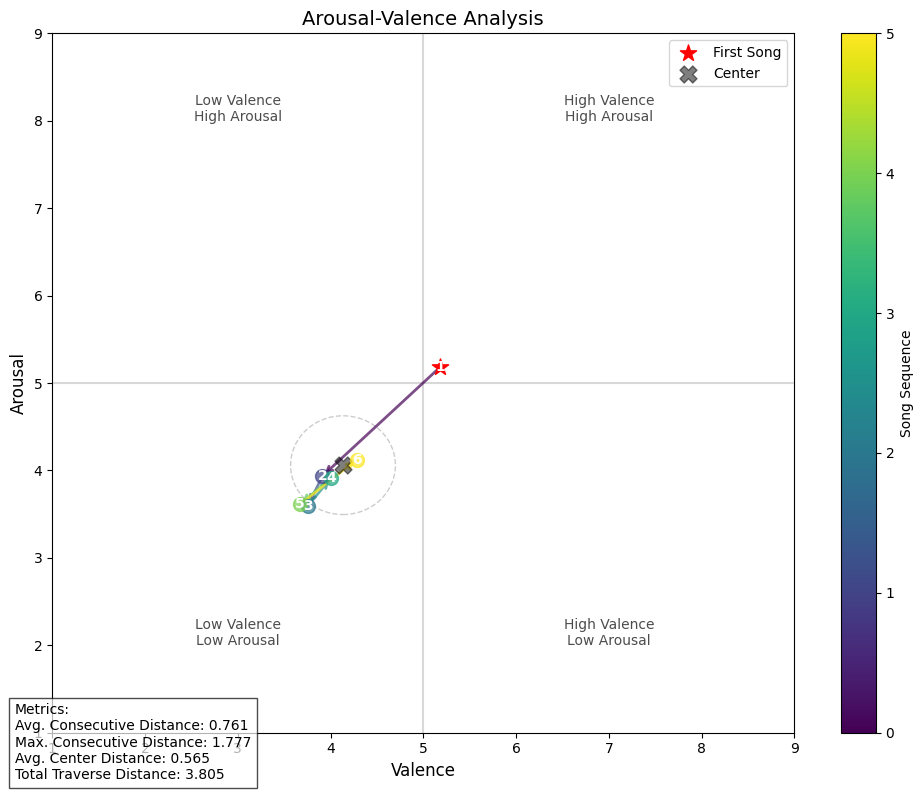

In [ ]:
evaluator.plot_arousal_valence_plane(results)

The listening models predict arousal and valence values within a [1,9] range in the emotional plane. The evaluator reveals that Vibe Sorcery generates playlists with smooth emotional transitions, as evidenced by an average Euclidean distance of 0.76 between consecutive songs. This moderate spacing suggests coherent emotional progression while maintaining variety.

Key observations from the emotional trajectory analysis:
1. Transition Consistency: The maximum distance between any song pair (1.77) remains relatively low, indicating no abrupt emotional jumps
2. Spatial Distribution: When plotting the average position and dispersion, all generated songs (excluding the input seed) fall within a circular region defined by the average distance from the centroid
3. Emotional Range: The playlist covers approximately 1.5 units in both arousal and valence dimensions, demonstrating focused yet nuanced emotional coverage

These quantitative measures collectively demonstrate Vibe Sorcery's ability to create playlists that are emotionally cohesive without being monotonous, maintaining listener engagement through carefully curated variations within a defined affective space.

## Evaluation of other playlists

### Playlist Psychosocial

Playlist generated using [Psychosocial - Slipknot](https://www.youtube.com/watch?v=5abamRO41fE) as input

In [ ]:
playlist_dict =  vibe_sorcerer.generate_playlist(input_song_path = 'Playlist Psychosocial/playlist_song_0.wav', num_songs = 5, duration = 47.0)

  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_1.wav
Generating song 2/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_2.wav
Generating song 3/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_3.wav
Generating song 4/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_4.wav
Generating song 5/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_5.wav
Vibe Sorcery completed!🎼🔮
Playlist generated with 5 songs.


In [ ]:
prev_song_caption = None
for i,song in enumerate(playlist_dict):
    print(f"Song #{i}")
    print(f"Input Caption: {prev_song_caption}")
    print("Moods extracted by the listener:", song[ "moods"])
    print("Caption:",song["caption"])
    prev_song_caption = song["caption"]
    print("------------------------------------------------------------------")

Song #0
Input Caption: None
Moods extracted by the listener: ['action', 'dark', 'epic', 'soundscape', 'space']
Caption: The perfect pumping soundtrack for your day
------------------------------------------------------------------
Song #1
Input Caption: The perfect pumping soundtrack for your day
Moods extracted by the listener: ['deep', 'film', 'happy', 'dark']
Caption: Music to feel happy, meaningful and mysterious
------------------------------------------------------------------
Song #2
Input Caption: Music to feel happy, meaningful and mysterious
Moods extracted by the listener: ['emotional', 'epic', 'film', 'inspiring', 'relaxing']
Caption: A emotional song with hints of peaceful undertones
------------------------------------------------------------------
Song #3
Input Caption: A emotional song with hints of peaceful undertones
Moods extracted by the listener: ['emotional', 'film', 'meditative', 'relaxing', 'romantic', 'sad']
Caption: A thematic tune for your blue, calming momen

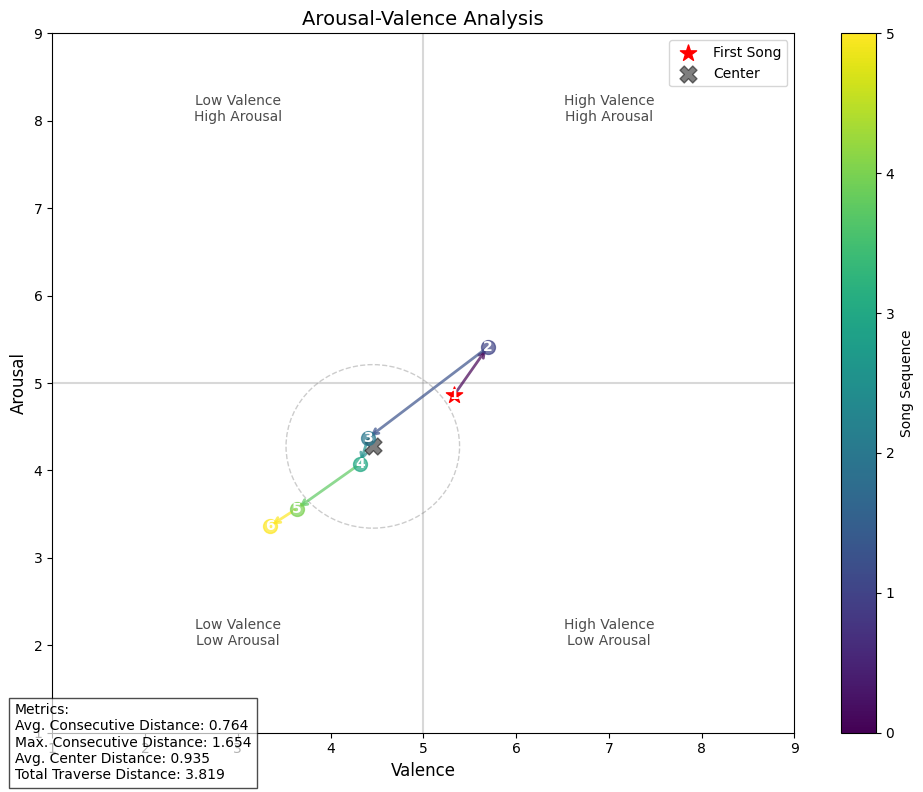

In [ ]:
results = evaluator.analyze_playlist('Playlist Psychosocial')
evaluator.plot_arousal_valence_plane(results)

### Playlist Little Monster

Playlist generated using [Little Monster - Royal Blood](https://www.youtube.com/watch?v=ere2Mstl8ww)

In [ ]:
playlist_dict =  vibe_sorcerer.generate_playlist(input_song_path = 'Playlist Little Monster/playlist_song_0.wav', num_songs = 5, duration = 47.0)

  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_1.wav
Generating song 2/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_2.wav
Generating song 3/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_3.wav
Generating song 4/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_4.wav
Generating song 5/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_5.wav
Vibe Sorcery completed!🎼🔮
Playlist generated with 5 songs.


In [ ]:
prev_song_caption = None
for i,song in enumerate(playlist_dict):
    print(f"Song #{i}")
    print(f"Input Caption: {prev_song_caption}")
    print("Moods extracted by the listener:", song[ "moods"])
    print("Caption:",song["caption"])
    prev_song_caption = song["caption"]
    print("------------------------------------------------------------------")

Song #0
Input Caption: None
Moods extracted by the listener: ['dark', 'epic', 'soundscape', 'space']
Caption: Music to feel dark, epic and interstellar
------------------------------------------------------------------
Song #1
Input Caption: Music to feel dark, epic and interstellar
Moods extracted by the listener: ['dream', 'emotional', 'film', 'meditative', 'relaxing', 'soundscape', 'space']
Caption: A expressive composition with soothing undertones
------------------------------------------------------------------
Song #2
Input Caption: A expressive composition with soothing undertones
Moods extracted by the listener: ['emotional', 'film', 'meditative', 'relaxing']
Caption: A expressive, film song
------------------------------------------------------------------
Song #3
Input Caption: A expressive, film song
Moods extracted by the listener: ['emotional', 'film', 'inspiring', 'meditative', 'relaxing', 'sad']
Caption: A expressive song with hints of peaceful, reflective undertones
--

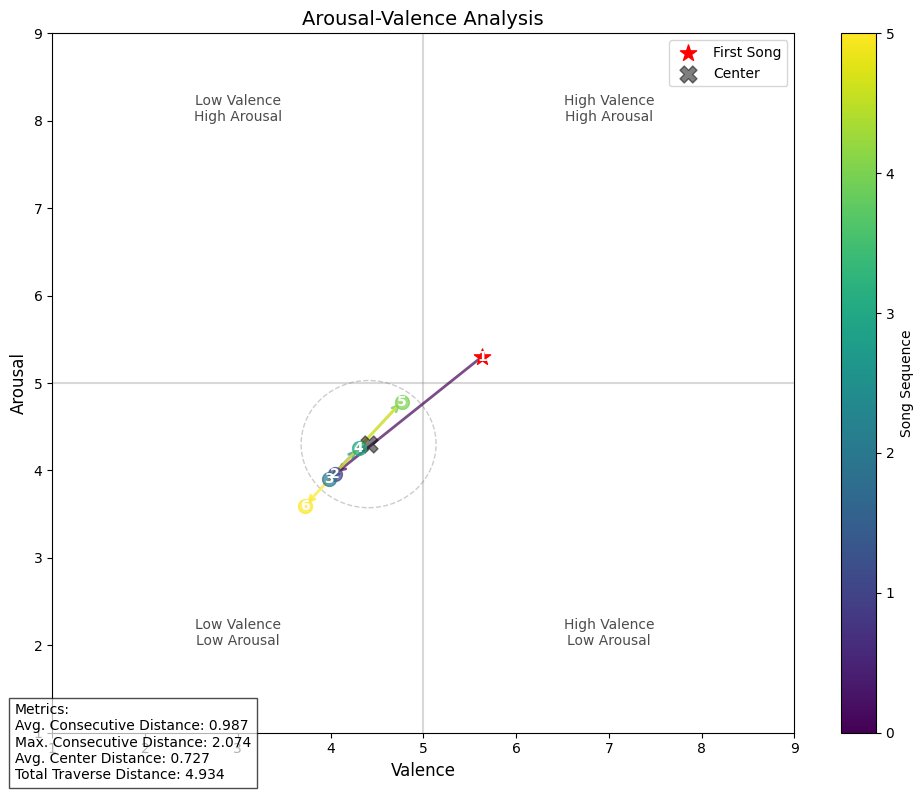

In [ ]:
results = evaluator.analyze_playlist('Playlist Little Monster')
evaluator.plot_arousal_valence_plane(results)

### Playlist Breathing

Playlist generated using [Breathing - Ben Böhmer](https://www.youtube.com/watch?v=TNRCvG9YtYI)

In [ ]:
playlist_dict =  vibe_sorcerer.generate_playlist(input_song_path = 'Random Playlist/playlist_song_0.wav', num_songs = 5, duration = 47.0)

  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_6.wav
Generating song 2/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_7.wav
Generating song 3/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_8.wav
Generating song 4/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_9.wav
Generating song 5/5...


  0%|          | 0/100 [00:00<?, ?it/s]

Song generated in: Random Playlist/playlist_song_10.wav
Vibe Sorcery completed!🎼🔮
Playlist generated with 5 songs.


In [ ]:
prev_song_caption = None
for i,song in enumerate(playlist_dict):
    print(f"Song #{i}")
    print(f"Input Caption: {prev_song_caption}")
    print("Moods extracted by the listener:", song[ "moods"])
    print("Caption:",song["caption"])
    prev_song_caption = song["caption"]
    print("------------------------------------------------------------------")

Song #0
Input Caption: None
Moods extracted by the listener: ['dark', 'film', 'meditative', 'relaxing', 'soundscape', 'space']
Caption: A song that blends relaxing, film and interstellar vibes
------------------------------------------------------------------
Song #1
Input Caption: A song that blends relaxing, film and interstellar vibes
Moods extracted by the listener: ['dream', 'emotional', 'film', 'meditative', 'relaxing', 'soundscape', 'space']
Caption: The perfect thematic, feeling, dream, relaxing, peaceful soundtrack for your day
------------------------------------------------------------------
Song #2
Input Caption: The perfect thematic, feeling, dream, relaxing, peaceful soundtrack for your day
Moods extracted by the listener: ['relaxing', 'meditative', 'emotional', 'sad']
Caption: A song that blends relaxing and sad, moving vibes
------------------------------------------------------------------
Song #3
Input Caption: A song that blends relaxing and sad, moving vibes
Moods e

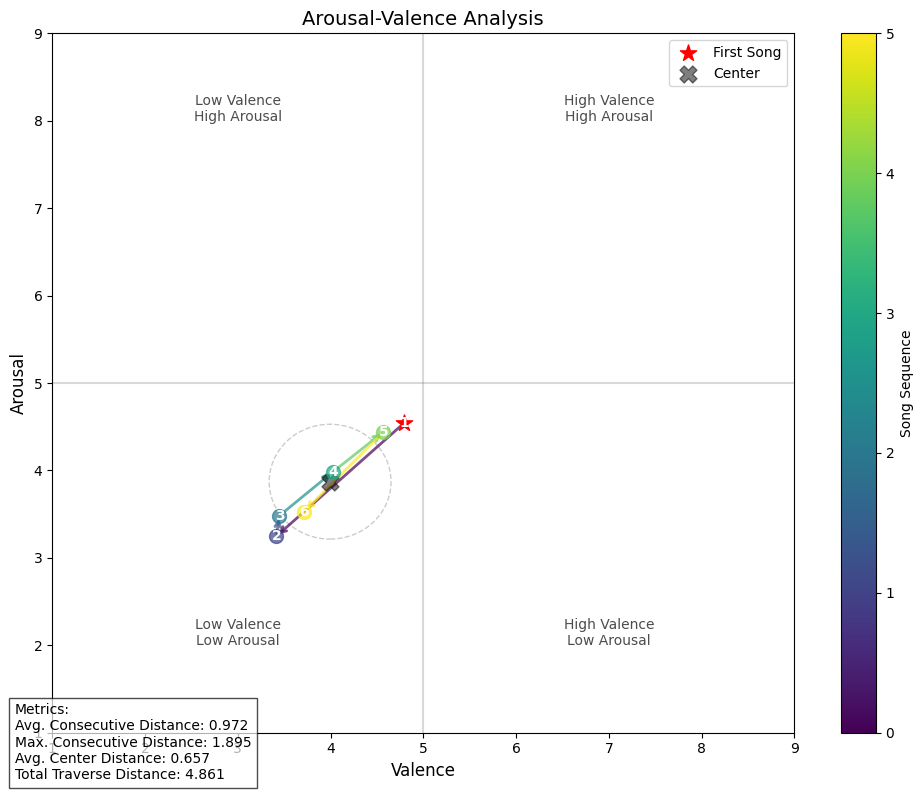

In [ ]:
results = evaluator.analyze_playlist('Random Playlist')
evaluator.plot_arousal_valence_plane(results)